In [1]:
import numpy as np
from keras.applications import vgg16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Ladataan CIFAR-10 datasetti, jaetaan validaatiojoukkoon, normalisoidaan kuvat ja muunnetaan etiketit kategoriamuotoon.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_val = x_train[:5000]
y_val = y_train[:5000]
x_train = x_train[5000:]
y_train = y_train[5000:]

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 56s 0us/step


Ladataan VGG-16 ilman dense-luokittelijakerroksia ja asetetaan mallin mainot olemaan oppimattomia, koska ei haluta muuttaa esikoulutetuja konvoluutioalustan painoja nopeuden vuoksi ja säilyttääksemme mallin tarkkuuden. Tämän avulla voimme käyttää VGG-16:ta feature extractorina, eli saadaan tiivistetyt piirteet jokaisesta kuvasta.

In [3]:
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

def extract_features(data):
    return conv_base.predict(data)

x_train_features = extract_features(x_train)
x_val_features = extract_features(x_val)
x_test_features = extract_features(x_test)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 198s 140ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step


Rakennetaan yksinkertainen dense-pohjainen luokittelija esikäsiteltyjen ominaisuuksien perusteella käyttäen kahta dense-kerrosta, jossa ensimmäisessä on aktivaatiofunktiona ReLU ja lopussa softmax-luokittelukerros ja kompiloidaan se käyttäen Adam-optimointia ja kategorista ristientropiaa.

In [4]:
malli = models.Sequential([
    layers.Input(shape=x_train_features.shape[1:]),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

malli.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

malli.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,898 (523.04 KB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = malli.fit(x_train_features, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val_features, y_val))

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4383 - loss: 1.5978 - val_accuracy: 0.5670 - val_loss: 1.2463
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5605 - loss: 1.2584 - val_accuracy: 0.5870 - val_loss: 1.1914
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5850 - loss: 1.1872 - val_accuracy: 0.5948 - val_loss: 1.1475
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 1.1447 - val_accuracy: 0.6002 - val_loss: 1.1278
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6106 - loss: 1.1136 - val_accuracy: 0.6124 - val_loss: 1.1188
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6192 - loss: 1.0899 - val_accuracy: 0.6114 - val_loss: 1.1085
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6290 - loss: 1.0630 - val_accuracy: 0.6196 - val_loss: 1.0987
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6343 - loss: 1.0426 - 

In [6]:
test_loss, test_acc = malli.evaluate(x_test_features, y_test)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6068 - loss: 1.1305
Test accuracy: 0.6055999994277954


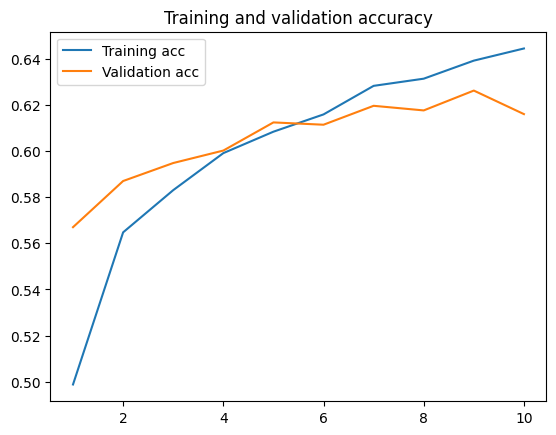

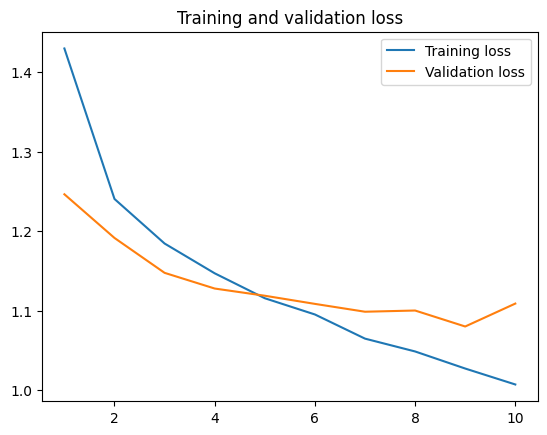

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()        

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Training and validation accuracy** graafin perusteella voidaan todeta, että malli oppii tehtävää kohtuullisesti. Validoinnin tarkkuus paranee aluksi, mutta tasaantuu myöhemmin, kun taas koulutuksen tarkkuus kasvaa tasaisesti, mikä viittaa siihen että mallin kyky yleistää uuteen dataan ei parane samaa tahtia kuin sen suorituskyky koulutusdatassa.


**Training and validation loss** graafin perusteella huomataan että häviö laskee tasaisesti kaikkien 10 epochin aikana, mikä viittaa siihen että malli mukautuu paremmin koulutusdataan ajan myötä. Validoinnin häviö laskee hieman aluksi, mutta alkaa vaihdella ja hieman kasvaa loppua kohti, mikä viittaa lievään ylioppimiseen.